In [ ]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report


In [ ]:
# Install gdown for downloading dataset from Google Drive
!pip install gdown -q

# ‚úÖ Step 1: Download dataset using gdown (Google Drive link)
!gdown --id 1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv -O /content/dataset_blood_group.zip

# ‚úÖ Step 2: Extract the dataset
import zipfile
import os

extract_path = "/content/dataset_blood_group"
with zipfile.ZipFile("/content/dataset_blood_group.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ‚úÖ Step 3: Ensure correct dataset folder (handle nested structures)
subfolders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
DATASET_PATH = os.path.join(extract_path, subfolders[0]) if len(subfolders) == 1 else extract_path

# ‚úÖ Step 4: List all class names (blood groups)
blood_groups = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
print("‚úÖ Classes found in dataset:", blood_groups)


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv
From (redirected): https://drive.google.com/uc?id=1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv&confirm=t&uuid=b4c35e59-f52b-4b38-9581-7a2c8564e3fb
To: /content/dataset_blood_group.zip
100% 77.8M/77.8M [00:01<00:00, 45.6MB/s]
‚úÖ Classes found in dataset: ['AB-', 'O-', 'O+', 'B-', 'A+', 'A-', 'B+', 'AB+']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

# ‚úÖ Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ‚úÖ Dictionary to store image counts per blood group
label_counts = {}

# ‚úÖ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ‚úÖ Check if it's a directory (avoid accidental file mismatches)
    if os.path.isdir(blood_group_path):
        # ‚úÖ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ‚úÖ Store count in dictionary
        label_counts[blood_group] = len(bmp_files)

# ‚úÖ Print counts for each blood group
print("\nüìÇ Blood Group Image Counts:")
for group, count in label_counts.items():
    print(f"üîπ {group}: {count} images")

# ‚úÖ Print total dataset size
total_images = sum(label_counts.values())
print("\n‚úÖ Total Dataset Size:", total_images, "images")



üìÇ Blood Group Image Counts:
üîπ A+: 1000 images
üîπ A-: 1000 images
üîπ AB+: 1000 images
üîπ AB-: 1000 images
üîπ B+: 1000 images
üîπ B-: 1000 images
üîπ O+: 1000 images
üîπ O-: 1000 images

‚úÖ Total Dataset Size: 8000 images


üìÇ First 5 rows of dataset:
                                            Filepath Label
0  /content/dataset_blood_group/dataset/AB+/clust...   AB+
1  /content/dataset_blood_group/dataset/AB+/clust...   AB+
2  /content/dataset_blood_group/dataset/A-/cluste...    A-
3  /content/dataset_blood_group/dataset/AB-/augme...   AB-
4  /content/dataset_blood_group/dataset/B+/cluste...    B+


<ipython-input-7-3f9b1d99e49b>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


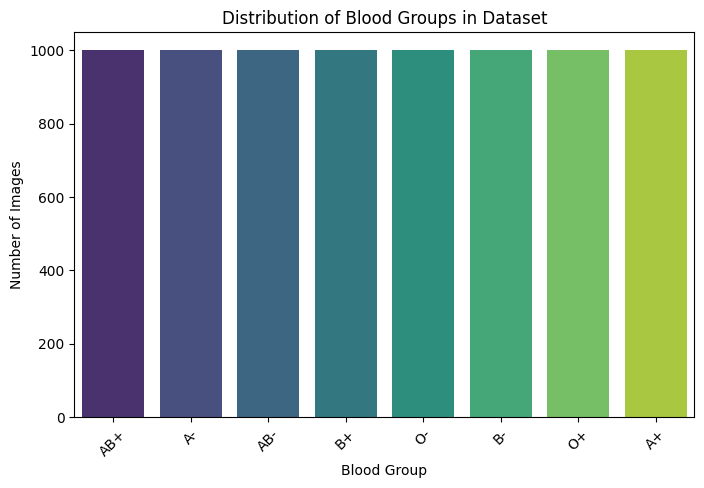


‚úÖ Total dataset size: 8000 images


In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ‚úÖ Step 1: Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ‚úÖ Step 2: Collect all image paths & labels
filepaths, labels = [], []

# ‚úÖ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ‚úÖ Check if it's a directory (avoiding any unwanted files)
    if os.path.isdir(blood_group_path):
        # ‚úÖ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ‚úÖ Store file paths & labels
        filepaths.extend(bmp_files)
        labels.extend([blood_group] * len(bmp_files))  # Assign label for each image

# ‚úÖ Step 3: Create a DataFrame with file paths & labels
data = pd.DataFrame({"Filepath": filepaths, "Label": labels})

# ‚úÖ Step 4: Shuffle dataset to ensure randomness
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Added random_state for reproducibility

# ‚úÖ Step 5: Display first 5 rows to check data
print("üìÇ First 5 rows of dataset:")
print(data.head())

# ‚úÖ Step 6: Count images per blood group
counts = data["Label"].value_counts()

# ‚úÖ Step 7: Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.xlabel("Blood Group")
plt.ylabel("Number of Images")
plt.title("Distribution of Blood Groups in Dataset")
plt.xticks(rotation=45)
plt.show()

# ‚úÖ Step 8: Print total dataset size
print(f"\n‚úÖ Total dataset size: {len(filepaths)} images")


‚úÖ Training set: 6400 images (80.0%)
‚úÖ Validation set: 1600 images (20.0%)


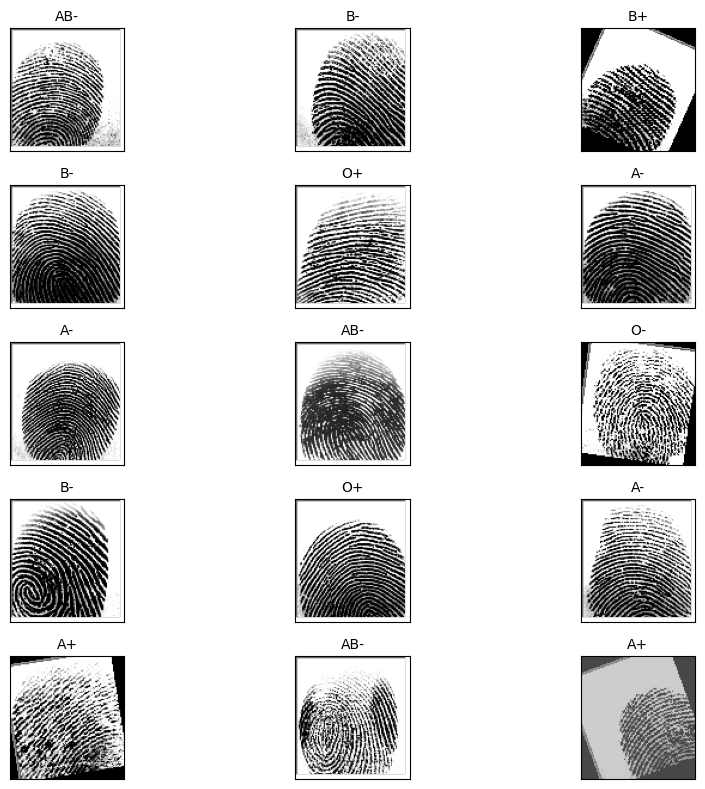


üìä Dataset Summary:
Label
AB+    1000
A-     1000
AB-    1000
B+     1000
O-     1000
B-     1000
O+     1000
A+     1000
Name: count, dtype: int64


In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# ‚úÖ Step 1: Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ‚úÖ Step 2: Collect image paths & labels
filepaths, labels = [], []

# ‚úÖ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ‚úÖ Ensure it's a valid directory (avoiding unwanted files)
    if os.path.isdir(blood_group_path):
        # ‚úÖ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ‚úÖ Store file paths & labels
        filepaths.extend(bmp_files)
        labels.extend([blood_group] * len(bmp_files))  # Assign label for each image

# ‚úÖ Step 3: Create a DataFrame with file paths & labels
data = pd.DataFrame({"Filepath": filepaths, "Label": labels}).sample(frac=1, random_state=42).reset_index(drop=True)

# ‚úÖ Step 4: Split dataset into Training (80%) and Validation (20%) with stratification
train_df, valid_df = train_test_split(data, test_size=0.20, stratify=data["Label"], random_state=42)

# ‚úÖ Print dataset sizes
print(f"‚úÖ Training set: {len(train_df)} images ({len(train_df)/len(data)*100:.1f}%)")
print(f"‚úÖ Validation set: {len(valid_df)} images ({len(valid_df)/len(data)*100:.1f}%)")

# ‚úÖ Step 5: Visualize random images from the dataset
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})

# Pick 15 random images (ensuring valid index)
random_samples = data.sample(n=15, random_state=42).reset_index(drop=True)

for i, ax in enumerate(axes.flat):
    if i < len(random_samples):  # Ensure no out-of-bounds errors
        img_path = random_samples.Filepath[i]  # Get file path
        label = random_samples.Label[i]  # Get blood group label

        ax.imshow(plt.imread(img_path))  # Load and display image
        ax.set_title(label, fontsize=10)  # Set title as blood group label

plt.tight_layout()
plt.show()

# ‚úÖ Print dataset stats
print("\nüìä Dataset Summary:")
print(data["Label"].value_counts())


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# ‚úÖ Define ImageDataGenerators (No validation split needed)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ‚úÖ Training Generator (Uses train_df directly)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# ‚úÖ Validation Generator (Uses valid_df directly)
valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 6400 validated image filenames belonging to 8 classes.
Found 1600 validated image filenames belonging to 8 classes.


In [ ]:
print(model.input_shape)


(None, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ‚úÖ Load Pretrained DenseNet121 Model
pretrained_model = DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# ‚úÖ Unfreeze the last 60 layers (Fine-tune deeper layers)
for layer in pretrained_model.layers[-60:]:
    layer.trainable = True

# ‚úÖ Fully Connected Layers
x = Dense(256, activation="relu")(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # ‚¨ÜÔ∏è Increased dropout to prevent overfitting
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # ‚¨ÜÔ∏è Increased dropout
outputs = Dense(8, activation='softmax')(x)

# ‚úÖ Create Model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# ‚úÖ Compile with Slightly Higher LR
model.compile(
    optimizer=Adam(learning_rate=0.00005),  # ‚¨ÜÔ∏è Increased LR for target accuracy
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ‚úÖ Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,  # ‚¨áÔ∏è Lower patience for faster adaptation
    min_lr=0.000001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,  # ‚¨áÔ∏è Stops earlier to avoid overfitting
    restore_best_weights=True,
    verbose=1
)

# ‚úÖ Train the Model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,  # ‚¨áÔ∏è Slightly reduced epochs
    batch_size=16,  # ‚¨áÔ∏è Lower batch size for better generalization
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232s 362ms/step - accuracy: 0.2384 - loss: 2.5236 - val_accuracy: 0.4837 - val_loss: 1.3992 - learning_rate: 5.0000e-05
Epoch 2/30
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62s 309ms/step - accuracy: 0.5142 - loss: 1.3531 - val_accuracy: 0.7650 - val_loss: 0.6803 - learning_rate: 5.0000e-05
Epoch 3/30
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 305ms/step - accuracy: 0.6610 - loss: 0.9445 - val_accuracy: 0.7969 - val_loss: 0.5276 - learning_rate: 5.0000e-05
Epoch 4/30
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 306ms/step - accuracy: 0.7416 - loss: 0.7436 - val_accuracy: 0.8419 - val_loss: 0.4303 - learning_rate: 5.0000e-05
Epoch 5/30
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 306ms/step - accuracy: 0.7803 - loss: 0.6217 - val_accuracy: 0.8619 - val_loss: 0.3658 - learning_rate: 5.0000e-05
Epoc

In [ ]:
model.save("model_blood_group_detection.h5")

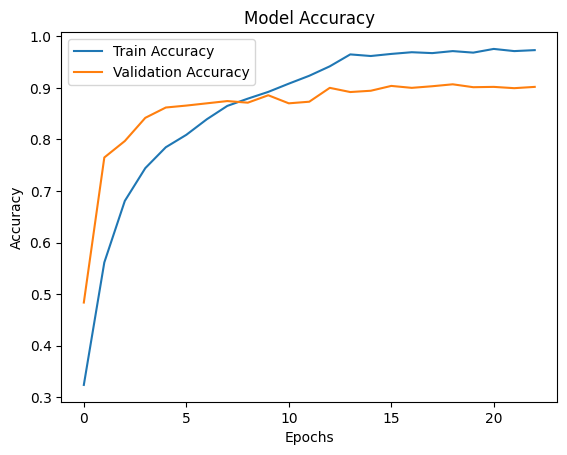

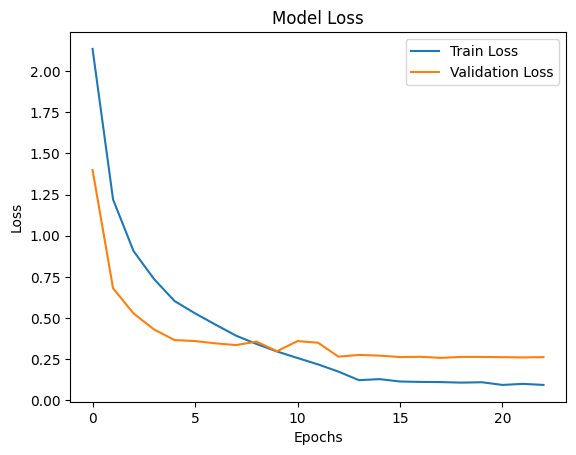

50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 80ms/step - accuracy: 0.8975 - loss: 0.2878
Test Loss: 0.26340
Test Accuracy: 90.69%
50/50 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 80ms/step
              precision    recall  f1-score   support

          A+       0.96      0.92      0.94       200
          A-       0.90      0.91      0.90       200
         AB+       0.87      0.94      0.90       200
         AB-       0.94      0.85      0.89       200
          B+       0.89      0.92      0.91       200
          B-       0.92      0.94      0.93       200
          O+       0.92      0.87      0.89       200
          O-       0.87      0.91      0.89       200

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600

Confusion Matrix:
 [[184   0   5   0   0   0   6   5]
 [  0 182   0   0   2   7   6   3]
 [  1   0 187   0  10   

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

# ‚úÖ Evaluate the model on the test set
results = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# ‚úÖ Predict labels for test data
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)  # Convert probabilities to class indices

# ‚úÖ Map predicted indices to class labels
class_indices = test_gen.class_indices
labels_map = {v: k for k, v in class_indices.items()}  # Reverse mapping
pred_labels = [labels_map[idx] for idx in pred_classes]

# ‚úÖ True labels from test set
true_labels = [labels_map[idx] for idx in test_gen.classes]  # Correct way to extract true labels

# ‚úÖ Print classification report
print(classification_report(true_labels, pred_labels))

# ‚úÖ Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", conf_matrix)


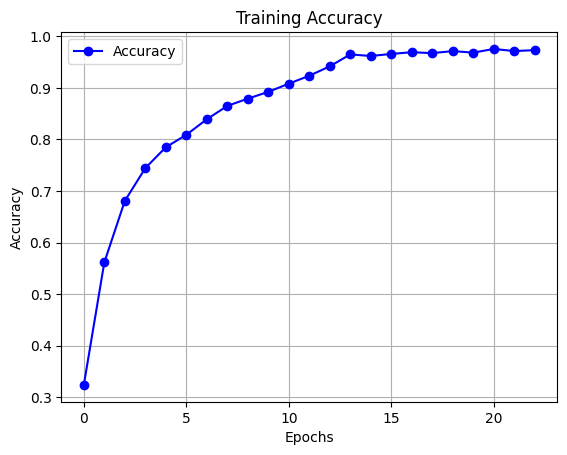

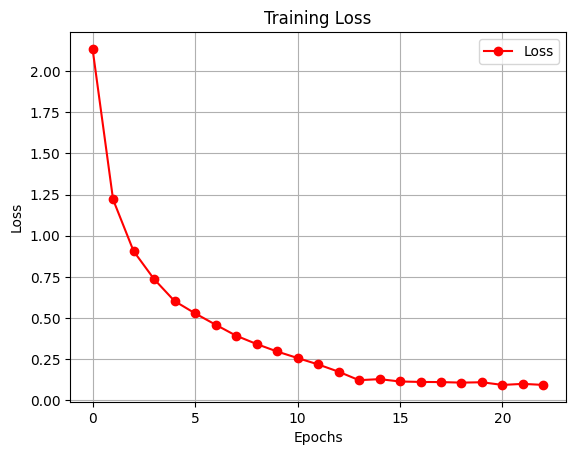

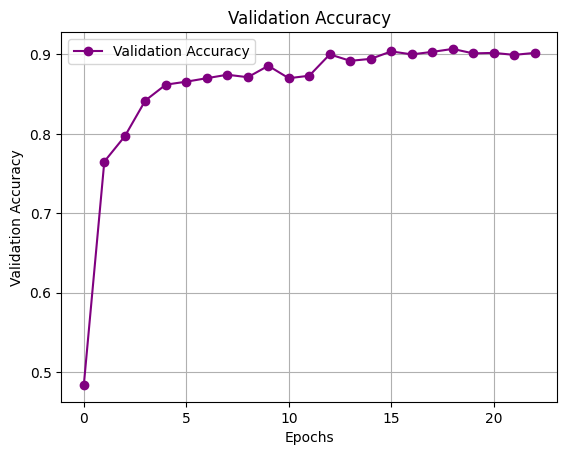

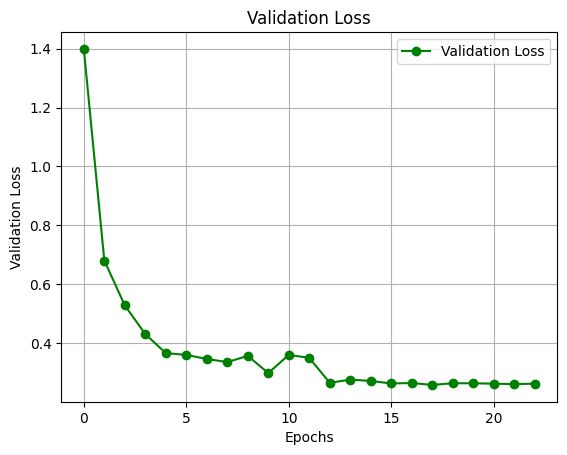

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='blue', label='Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()
plt.plot(history.history['loss'], marker='o', linestyle='-', color='red', label='Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', color='purple', label='Validation Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid()
plt.legend()
plt.show()
plt.plot(history.history['val_loss'], marker='o', linestyle='-', color='green', label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.legend()
plt.show()


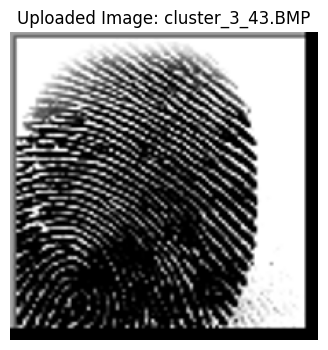

‚úÖ Predicted Blood Group: A+
üéØ Confidence: 100.00%


Do you want to continue?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import display, clear_output, HTML
from PIL import Image as PILImage
import io
from google.colab import files

# Load the model
model = load_model("model_blood_group_detection.h5")

# Blood group labels
labels = {0: 'A+', 1: 'A-', 2: 'AB+', 3: 'AB-', 4: 'B+', 5: 'B-', 6: 'O+', 7: 'O-'}

# Function to restart prediction
def handle_yes(_):
    clear_output()
    predict_blood_group()

# Function to exit
def handle_no(_):
    clear_output()
    display(HTML("<p style='font-weight: bold; font-size: 16px; color: #4CAF50;'>Thank you for using the Blood Group Detection App!</p>"))

# Create button widgets
yes_button = widgets.Button(description="Yes", button_style="success")
no_button = widgets.Button(description="No", button_style="danger")

# Assign button handlers
yes_button.on_click(handle_yes)
no_button.on_click(handle_no)

def predict_blood_group():
    display(HTML("<p style='font-weight: bold; color: #2196F3;'>Uploading image...</p>"))
    uploaded = files.upload()

    if not uploaded:
        display(HTML("<p style='color: red;'>No file uploaded. Please try again.</p>"))
        return

    file_name = next(iter(uploaded))
    img_bytes = uploaded[file_name]

    clear_output()
    display(HTML("<p style='font-weight: bold; color: #2196F3;'>Predicting blood group... Please wait.</p>"))

    img = PILImage.open(io.BytesIO(img_bytes)).convert("RGB").resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    result = model.predict(x)
    predicted_class = np.argmax(result)
    predicted_label = labels[predicted_class]
    confidence = result[0][predicted_class] * 100

    clear_output()
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {file_name}")
    plt.axis('off')
    plt.show()

    print(f"‚úÖ Predicted Blood Group: {predicted_label}")
    print(f"üéØ Confidence: {confidence:.2f}%")

    print("\n\nDo you want to continue?")
    display(widgets.HBox([yes_button, no_button]))

# Start the application
predict_blood_group()